## 6.1 매개변수 갱신
### 6.1.2 확률적 경사 하강법(SGD)
SGD는 비등방성(anisotropy) 함수(방향에 따라 성질, 즉 여기에서는 기울기가 달라지는 함수)에서는 탐색 경로가 비효율적임.

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 6.1.4 모멘텀

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

### 6.1.5 AdaGrad

In [4]:
import numpy as np

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 6.2 가중치의 초깃값
### 6.2.2 은닉층의 활성화값 분포
- 활성화 함수로 ReLU를 사용: He 초깃값
- 활성화 함수로 sigmoid나 tanh 등의 S자 모양 곡선 사용: Xavier 초깃값

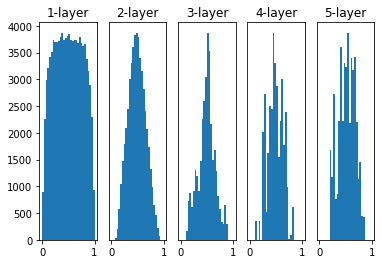

In [8]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

### 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

===========iteration:0===========
std=0.01:2.3025536973231375
Xavier:2.2961706328395515
He:2.3251117319591477
===========iteration:100===========
std=0.01:2.3022992301829657
Xavier:2.235501052300578
He:1.4091641653917208
===========iteration:200===========
std=0.01:2.3011852958352694
Xavier:2.1147483608201805
He:0.7117225768992722
===========iteration:300===========
std=0.01:2.303170166305585
Xavier:1.9087450970105766
He:0.6433453958717753
===========iteration:400===========
std=0.01:2.3030224535513804
Xavier:1.3289779268251305
He:0.5407519352284582
===========iteration:500===========
std=0.01:2.3008304351029616
Xavier:0.8663676196809116
He:0.36760815875320063
===========iteration:600===========
std=0.01:2.3000228259751796
Xavier:0.6277135116591595
He:0.31238577005887724
===========iteration:700===========
std=0.01:2.3018020375743546
Xavier:0.5739629095785451
He:0.33116030543825065
===========iteration:800===========
std=0.01:2.308175611090916
Xavier:0.4464847504482858
He:0.29256638182

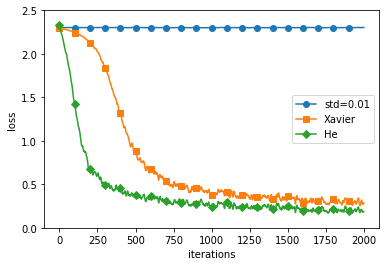

In [9]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

### 6.3.2 배치 정규화의 효과

============== 1/16 ==============
epoch:0 | 0.097 - 0.119


/workspace/Python-Deep-Learning/src/Deep Learning from Scratch 1/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.146
epoch:2 | 0.097 - 0.136
epoch:3 | 0.097 - 0.146
epoch:4 | 0.097 - 0.16
epoch:5 | 0.097 - 0.172
epoch:6 | 0.097 - 0.193
epoch:7 | 0.097 - 0.201
epoch:8 | 0.097 - 0.234
epoch:9 | 0.097 - 0.251
epoch:10 | 0.097 - 0.272
epoch:11 | 0.097 - 0.299
epoch:12 | 0.097 - 0.313
epoch:13 | 0.097 - 0.322
epoch:14 | 0.097 - 0.345
epoch:15 | 0.097 - 0.357
epoch:16 | 0.097 - 0.367
epoch:17 | 0.097 - 0.399
epoch:18 | 0.097 - 0.407


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.427
============== 2/16 ==============
epoch:0 | 0.094 - 0.101


/workspace/Python-Deep-Learning/src/Deep Learning from Scratch 1/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/workspace/Python-Deep-Learning/src/Deep Learning from Scratch 1/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/workspace/Python-Deep-Learning/src/Deep Learning from Scratch 1/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.124
epoch:2 | 0.097 - 0.137
epoch:3 | 0.097 - 0.147
epoch:4 | 0.097 - 0.172
epoch:5 | 0.097 - 0.188
epoch:6 | 0.097 - 0.21
epoch:7 | 0.097 - 0.232
epoch:8 | 0.097 - 0.266
epoch:9 | 0.097 - 0.286
epoch:10 | 0.097 - 0.304
epoch:11 | 0.097 - 0.339
epoch:12 | 0.097 - 0.358
epoch:13 | 0.097 - 0.379
epoch:14 | 0.097 - 0.406
epoch:15 | 0.097 - 0.427
epoch:16 | 0.097 - 0.439
epoch:17 | 0.097 - 0.46
epoch:18 | 0.097 - 0.48


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.484
============== 3/16 ==============
epoch:0 | 0.147 - 0.092
epoch:1 | 0.267 - 0.104
epoch:2 | 0.406 - 0.143
epoch:3 | 0.515 - 0.222
epoch:4 | 0.587 - 0.264
epoch:5 | 0.649 - 0.31
epoch:6 | 0.68 - 0.351
epoch:7 | 0.742 - 0.384
epoch:8 | 0.78 - 0.4
epoch:9 | 0.81 - 0.439
epoch:10 | 0.836 - 0.467
epoch:11 | 0.862 - 0.495
epoch:12 | 0.87 - 0.518
epoch:13 | 0.897 - 0.542
epoch:14 | 0.916 - 0.56
epoch:15 | 0.922 - 0.581
epoch:16 | 0.934 - 0.607
epoch:17 | 0.935 - 0.614
epoch:18 | 0.947 - 0.635


No handles with labels found to put in legend.


epoch:19 | 0.959 - 0.663
============== 4/16 ==============
epoch:0 | 0.102 - 0.072
epoch:1 | 0.21 - 0.095
epoch:2 | 0.378 - 0.155
epoch:3 | 0.507 - 0.207
epoch:4 | 0.581 - 0.286
epoch:5 | 0.624 - 0.371
epoch:6 | 0.669 - 0.431
epoch:7 | 0.683 - 0.487
epoch:8 | 0.735 - 0.544
epoch:9 | 0.761 - 0.583
epoch:10 | 0.77 - 0.619
epoch:11 | 0.79 - 0.65
epoch:12 | 0.788 - 0.673
epoch:13 | 0.813 - 0.706
epoch:14 | 0.82 - 0.74
epoch:15 | 0.834 - 0.744
epoch:16 | 0.834 - 0.76
epoch:17 | 0.836 - 0.776
epoch:18 | 0.854 - 0.783


No handles with labels found to put in legend.


epoch:19 | 0.864 - 0.799
============== 5/16 ==============
epoch:0 | 0.1 - 0.115
epoch:1 | 0.102 - 0.155
epoch:2 | 0.102 - 0.263
epoch:3 | 0.112 - 0.35
epoch:4 | 0.121 - 0.439
epoch:5 | 0.122 - 0.537
epoch:6 | 0.133 - 0.605
epoch:7 | 0.145 - 0.668
epoch:8 | 0.169 - 0.697
epoch:9 | 0.184 - 0.732
epoch:10 | 0.198 - 0.748
epoch:11 | 0.219 - 0.771
epoch:12 | 0.219 - 0.795
epoch:13 | 0.233 - 0.807
epoch:14 | 0.241 - 0.818
epoch:15 | 0.259 - 0.832
epoch:16 | 0.259 - 0.842
epoch:17 | 0.268 - 0.852
epoch:18 | 0.264 - 0.868


No handles with labels found to put in legend.


epoch:19 | 0.257 - 0.875
============== 6/16 ==============
epoch:0 | 0.072 - 0.112
epoch:1 | 0.117 - 0.179
epoch:2 | 0.117 - 0.432
epoch:3 | 0.117 - 0.573
epoch:4 | 0.117 - 0.634
epoch:5 | 0.117 - 0.693
epoch:6 | 0.134 - 0.736
epoch:7 | 0.134 - 0.77
epoch:8 | 0.153 - 0.795
epoch:9 | 0.121 - 0.816
epoch:10 | 0.117 - 0.831
epoch:11 | 0.117 - 0.84
epoch:12 | 0.117 - 0.87
epoch:13 | 0.119 - 0.878
epoch:14 | 0.117 - 0.891
epoch:15 | 0.119 - 0.909
epoch:16 | 0.117 - 0.915
epoch:17 | 0.192 - 0.923
epoch:18 | 0.136 - 0.933


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.936
============== 7/16 ==============
epoch:0 | 0.105 - 0.095
epoch:1 | 0.105 - 0.251
epoch:2 | 0.105 - 0.486
epoch:3 | 0.105 - 0.68
epoch:4 | 0.117 - 0.782
epoch:5 | 0.117 - 0.832
epoch:6 | 0.117 - 0.851
epoch:7 | 0.117 - 0.882
epoch:8 | 0.117 - 0.905
epoch:9 | 0.117 - 0.925
epoch:10 | 0.117 - 0.944
epoch:11 | 0.117 - 0.95
epoch:12 | 0.117 - 0.96
epoch:13 | 0.117 - 0.965
epoch:14 | 0.117 - 0.972
epoch:15 | 0.117 - 0.977
epoch:16 | 0.117 - 0.983
epoch:17 | 0.117 - 0.985
epoch:18 | 0.117 - 0.986


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.99
============== 8/16 ==============
epoch:0 | 0.085 - 0.113
epoch:1 | 0.1 - 0.444
epoch:2 | 0.116 - 0.691
epoch:3 | 0.116 - 0.773
epoch:4 | 0.116 - 0.813
epoch:5 | 0.116 - 0.843
epoch:6 | 0.116 - 0.882
epoch:7 | 0.116 - 0.917
epoch:8 | 0.116 - 0.93
epoch:9 | 0.116 - 0.947
epoch:10 | 0.131 - 0.967
epoch:11 | 0.117 - 0.977
epoch:12 | 0.117 - 0.983
epoch:13 | 0.117 - 0.987
epoch:14 | 0.117 - 0.993
epoch:15 | 0.117 - 0.994
epoch:16 | 0.117 - 0.994
epoch:17 | 0.117 - 0.994
epoch:18 | 0.117 - 0.995


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.996
============== 9/16 ==============
epoch:0 | 0.105 - 0.129
epoch:1 | 0.105 - 0.347
epoch:2 | 0.094 - 0.713
epoch:3 | 0.117 - 0.827
epoch:4 | 0.117 - 0.897
epoch:5 | 0.116 - 0.933
epoch:6 | 0.116 - 0.965
epoch:7 | 0.117 - 0.977
epoch:8 | 0.117 - 0.98
epoch:9 | 0.117 - 0.993
epoch:10 | 0.117 - 0.995
epoch:11 | 0.117 - 0.997
epoch:12 | 0.117 - 0.997
epoch:13 | 0.117 - 0.999
epoch:14 | 0.117 - 0.999
epoch:15 | 0.117 - 0.999
epoch:16 | 0.117 - 1.0
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.092 - 0.121
epoch:1 | 0.117 - 0.483
epoch:2 | 0.117 - 0.718
epoch:3 | 0.117 - 0.752
epoch:4 | 0.117 - 0.815
epoch:5 | 0.117 - 0.845
epoch:6 | 0.117 - 0.914
epoch:7 | 0.117 - 0.89
epoch:8 | 0.117 - 0.964
epoch:9 | 0.117 - 0.963
epoch:10 | 0.116 - 0.952
epoch:11 | 0.117 - 0.989
epoch:12 | 0.116 - 0.994
epoch:13 | 0.116 - 0.993
epoch:14 | 0.116 - 0.996
epoch:15 | 0.116 - 0.996
epoch:16 | 0.116 - 0.996
epoch:17 | 0.116 - 0.995
epoch:18 | 0.116 - 0.996


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.117 - 0.155
epoch:1 | 0.116 - 0.607
epoch:2 | 0.116 - 0.706
epoch:3 | 0.116 - 0.678
epoch:4 | 0.116 - 0.669
epoch:5 | 0.116 - 0.692
epoch:6 | 0.116 - 0.731
epoch:7 | 0.117 - 0.699
epoch:8 | 0.117 - 0.867
epoch:9 | 0.117 - 0.755
epoch:10 | 0.117 - 0.88
epoch:11 | 0.117 - 0.865
epoch:12 | 0.117 - 0.883
epoch:13 | 0.116 - 0.889
epoch:14 | 0.116 - 0.899
epoch:15 | 0.116 - 0.895
epoch:16 | 0.116 - 0.9
epoch:17 | 0.116 - 0.901
epoch:18 | 0.116 - 0.897


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.895
============== 12/16 ==============
epoch:0 | 0.116 - 0.174
epoch:1 | 0.116 - 0.386
epoch:2 | 0.116 - 0.557
epoch:3 | 0.116 - 0.57
epoch:4 | 0.117 - 0.619
epoch:5 | 0.116 - 0.654
epoch:6 | 0.116 - 0.617
epoch:7 | 0.116 - 0.673
epoch:8 | 0.116 - 0.686
epoch:9 | 0.116 - 0.691
epoch:10 | 0.116 - 0.703
epoch:11 | 0.116 - 0.705
epoch:12 | 0.116 - 0.703
epoch:13 | 0.116 - 0.702
epoch:14 | 0.116 - 0.698
epoch:15 | 0.116 - 0.706
epoch:16 | 0.116 - 0.698
epoch:17 | 0.116 - 0.707
epoch:18 | 0.117 - 0.707


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.707
============== 13/16 ==============
epoch:0 | 0.116 - 0.144
epoch:1 | 0.117 - 0.533
epoch:2 | 0.117 - 0.626
epoch:3 | 0.117 - 0.66
epoch:4 | 0.117 - 0.654
epoch:5 | 0.117 - 0.681
epoch:6 | 0.117 - 0.692
epoch:7 | 0.117 - 0.724
epoch:8 | 0.117 - 0.734
epoch:9 | 0.117 - 0.729
epoch:10 | 0.117 - 0.739
epoch:11 | 0.117 - 0.77
epoch:12 | 0.117 - 0.759
epoch:13 | 0.117 - 0.784
epoch:14 | 0.117 - 0.753
epoch:15 | 0.117 - 0.789
epoch:16 | 0.117 - 0.794
epoch:17 | 0.117 - 0.796
epoch:18 | 0.117 - 0.794


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.798
============== 14/16 ==============
epoch:0 | 0.087 - 0.127
epoch:1 | 0.117 - 0.353
epoch:2 | 0.117 - 0.373
epoch:3 | 0.117 - 0.367
epoch:4 | 0.117 - 0.412
epoch:5 | 0.117 - 0.465
epoch:6 | 0.117 - 0.427
epoch:7 | 0.117 - 0.573
epoch:8 | 0.117 - 0.502
epoch:9 | 0.117 - 0.506
epoch:10 | 0.117 - 0.584
epoch:11 | 0.117 - 0.57
epoch:12 | 0.117 - 0.598
epoch:13 | 0.117 - 0.603
epoch:14 | 0.117 - 0.593
epoch:15 | 0.117 - 0.591
epoch:16 | 0.117 - 0.677
epoch:17 | 0.117 - 0.701
epoch:18 | 0.117 - 0.679


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.701
============== 15/16 ==============
epoch:0 | 0.116 - 0.097
epoch:1 | 0.105 - 0.299
epoch:2 | 0.105 - 0.379
epoch:3 | 0.116 - 0.412
epoch:4 | 0.116 - 0.402
epoch:5 | 0.116 - 0.418
epoch:6 | 0.117 - 0.42
epoch:7 | 0.117 - 0.421
epoch:8 | 0.117 - 0.421
epoch:9 | 0.117 - 0.424
epoch:10 | 0.117 - 0.433
epoch:11 | 0.117 - 0.429
epoch:12 | 0.117 - 0.422
epoch:13 | 0.117 - 0.514
epoch:14 | 0.117 - 0.504
epoch:15 | 0.116 - 0.519
epoch:16 | 0.117 - 0.518
epoch:17 | 0.117 - 0.613
epoch:18 | 0.117 - 0.583


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.525
============== 16/16 ==============
epoch:0 | 0.117 - 0.24
epoch:1 | 0.117 - 0.239
epoch:2 | 0.116 - 0.318
epoch:3 | 0.116 - 0.314
epoch:4 | 0.117 - 0.337
epoch:5 | 0.117 - 0.334
epoch:6 | 0.117 - 0.332
epoch:7 | 0.117 - 0.413
epoch:8 | 0.117 - 0.381
epoch:9 | 0.117 - 0.413
epoch:10 | 0.117 - 0.416
epoch:11 | 0.117 - 0.418
epoch:12 | 0.117 - 0.42
epoch:13 | 0.117 - 0.423
epoch:14 | 0.117 - 0.424
epoch:15 | 0.117 - 0.414
epoch:16 | 0.117 - 0.421
epoch:17 | 0.117 - 0.411
epoch:18 | 0.117 - 0.425
epoch:19 | 0.117 - 0.176


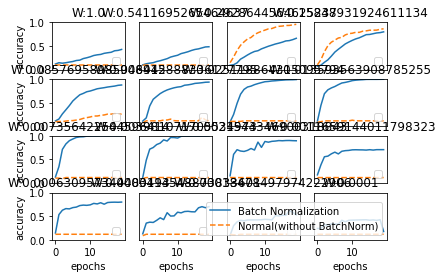

In [10]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

## 6.4 바른 학습을 위해
### 6.4.1 오버피팅
오버피팅이 일어나는 주된 경우들
- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음

### 6.4.2 가중치 감소
### 6.4.3 드롭아웃

In [11]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask

## 6.5 적절한 하이퍼파라미터 값 찾기
### 6.5.2 하이퍼파라미터 최적화
- 0단계: 하이퍼파라미터 값의 범위를 설정
- 1단계: 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출
- 2단계: 1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가(단, 에폭은 작게 설정)
- 3단계: 1단계와 2단계를 특정 횟수(100회 등) 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힘.